# Wildcard Handling with Astroquery.mast

----

## Learning Goals

By the end of this tutorial, you will:

* Learn about the wildcards available for `astroquery.mast.Observations` criteria queries
* Learn how to use these wildcards to broaden or refine `astroquery.mast.Observations` criteria queries
* Learn the downfalls of the `instrument_name` criteria, particularly for JWST queries
* Learn how to query for moving targets using target ephemeris and time criteria such as `t_min` and `t_max` for more advanced searches

## Introduction

This notebook will demonstrate the use of wildcards in `astroquery.mast.Observations` criteria queries. The use of wildcards is encouraged for certain criteria types (`string` object types) to ensure that your query results capture what is truly available on MAST. We will use 3 examples to demonstrate some use-cases for wildcards when doing criteria queries, and to emphasize on certain criteria where wildcard usage is highly encouraged, particularly for JWST queries. We will also use the last example to demonstrate the use of value ranges when working with `float` object criteria types.

The workflow for this notebook consists of:

* Wildcards with `astroquery.mast.Observations`
    * Wildcard Search with `instrument_name`
    * Wildcard Search with `instrument_name` and `proposal_id`
    * Wildcard Search a Time-sensitive Object with `target_name` and `t_min`
    * Resources

## Imports

In [84]:
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import Table, unique, vstack
from astropy.time import Time
from astroquery.mast import Observations

----

## Wildcards with `astroquery.mast.Observations`

The use of wildcards when making `astroquery.mast.Observations` queries can help ensure you retrieve all observations without leaving anything out. The available wildcards are `%` and `*` with `%` serving to replace a single character, and `*` serving to replace more than one character preceding, following, or in between the existing characters, depending on its placement. See the [Observation Criteria Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries) section in the `astroquery.mast` documentation for more information on the wildcards.

With that being said, wildcards are only available for certain criteria. Those criteria that are `string` type objects are criteria that accept wildcards, but `float`, `integer`, or any other objects do not accept wildcards.

Users may call the `get_metadata` method to see the list of criteria that can be queried with. The criteria listed as `string` objects under the **Data Type** column are criteria that can be called with wildcards:

In [46]:
Observations.get_metadata("observations").show_in_notebook()

idx,Column Name,Column Label,Data Type,Units,Description,Examples/Valid Values
0,intentType,Observation Type,string,,Whether observation is for science or calibration.,"Valid values: science, calibration"
1,obs_collection,Mission,string,,Collection,"E.g. SWIFT, PS1, HST, IUE"
2,provenance_name,Provenance Name,string,,"Provenance name, or source of data","E.g. TASOC, CALSTIS, PS1"
3,instrument_name,Instrument,string,,Instrument Name,"E.g. WFPC2/WFC, UVOT, STIS/CCD"
4,project,Project,string,,Processing project,"E.g. HST, HLA, EUVE, hlsp_legus"
5,filters,Filters,string,,Instrument filters,"F469N, NUV, FUV, LOW DISP, MIRROR"
6,wavelength_region,Waveband,string,,Energy Band,"EUV, XRAY, OPTICAL"
7,target_name,Target Name,string,,Target Name,Ex. COMET-67P-CHURYUMOV-GER-UPDATE
8,target_classification,Target Classification,string,,Type of target,Ex. COMET;COMET BEING ORBITED BY THE ROSETTA SPACECRAFT;SOLAR SYSTEM
9,obs_id,Observation ID,string,,"Observation identifier, given by mission","U24Z0101T, N4QF18030"


### Wildcard Search with `instrument_name`

For our first example we will search for all NIRISS observations taken by a certain proposal/program PI. For this case, our two criteria we query with are `proposal_pi` and `instrument_name`, which are both `string` object criteria. As such, both can be wildcarded for ease of use. In fact, there may be cases where it is necessary to wildcard the `instrument_name` variable. This is because the JWST science instrument names on MAST have been modified to include configuration information for more precise advanced searches. However, this may lead to an incomplete list of observations returned for those who are not trying to do an advanced search. 

We will demonstrate this by looking at the results for the query below:

In [157]:
observations = Observations.query_criteria(proposal_pi="Espinoza, Nestor",
                                           instrument_name="*NIRISS*")
observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str13,str8,str13,str1,str50,float64,float64,str8,str16,int64,float64,float64,float64,float64,float64,str70,float64,str4,str3,int64,str158,str63,str81,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRISS,JWST,F277W/GR700XD,Infrared,HAT-P-14,--,jw01541-o001_t002_niriss_f277w-gr700xd-substrip256,260.1161716666666,38.24216944444444,spectrum,"Espinoza, Nestor",3,59738.26121625,59738.55835982639,384.785,600.0,3200.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 260.16189536 38.23724946 260.11337073 38.23746108 260.11348004 38.24619441 260.16201403 38.24597997 260.16189536 38.23724946,--,mast:JWST/product/jw01541-o001_t002_niriss_f277w-gr700xd-substrip256_x1dints.fits,PUBLIC,False,nan,85715273,195816449
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00001_nis,261.2178643508574,60.43078346928282,image,"Espinoza, Nestor",2,59995.98101357639,59995.98102200231,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18175925,1512,CAL,--,POLYGON 261.218693113 60.429993446 261.216484201 60.430416356 261.217327028 60.431499222 261.219536203 60.431076276,mast:JWST/product/jw01512002001_02101_00001_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00001_nis_cal.fits,PUBLIC,False,nan,117933629,255695241
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00004_nis,261.2178643508749,60.43078346928948,image,"Espinoza, Nestor",2,59995.98740097222,59995.98740939815,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18133101,1512,CAL,--,POLYGON 261.218665628 60.430005149 261.21645672 60.430428066 261.21729956 60.431510929 261.219508731 60.431087978,mast:JWST/product/jw01512002001_02101_00004_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00004_nis_cal.fits,PUBLIC,False,nan,117933631,255695252
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00003_nis,261.2178643508621,60.43078346928461,image,"Espinoza, Nestor",2,59995.98273135417,59995.98273978009,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18243051,1512,CAL,--,POLYGON 261.218532548 60.430043518 261.216323637 60.430466434 261.217166476 60.431549298 261.219375651 60.431126347,mast:JWST/product/jw01512002001_02101_00003_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00003_nis_cal.fits,PUBLIC,False,nan,117933632,255695267
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,BD+60-1753,--,jw01512002001_03101_00001_nis,261.2178643508796,60.43078346929124,image,"Espinoza, Nestor",2,59995.98902444445,59995.98915162037,5.494,500.0,5000.0,SOSS Wavelength and Trace,59996.02287034,1512,CAL,--,POLYGON 261.252875018 60.462615326 261.225284884 60.427069921 261.208823688 60.430220008 261.236381292 60.465773165,mast:JWST/product/jw01512002001_03101_00001_nis_trapsfilled.jpg,mast:JWST/product/jw01512002001_03101_00001_nis_rateints.fits,PUBLIC,False,nan,117933633,255695284
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00002_nis,261.2178643508597,60.4307834692837,image,"Espinoza, Nestor",2,59995.98186616898,59995.98187459491,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18305556,1512,CAL,--,POLYGON 261.218570044 60.429939833 261.216361139 60.430362749 261.217203974 60.431445613 261.219413143 60.431022662,mast:JWST/product/jw01512002001_02101_00002_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00002_nis_cal.fits,PUBLIC,False,nan,117933634,255695293
science,JWST,CALJWST,NIRISS/IMAGE,JWST,CLEAR;GR700XD,INFRARED,BD+60-1753,--,jw01512002001_03102_00001_nis,261.2178643508855,60.43078346929347,image,"Espinoza, Nesto

Here we have a list of all kinda of NIRISS observations led by the PI Dr. Espinoza. Let's call for all the unique values under the `instrument_name` column to see what was returned thanks to our `*` wildcards.

In [158]:
set(observations['instrument_name'])

{'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS'}

As you can see, there were some observations with `instrument_name` labeled something other than `NIRISS`, due to the new configuration on MAST. Had we only searched for the `instrument_name` value `NIRISS`, we would have missed several observations. For the full list of instrument name variations, you can refer to [this page](https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names).

**Note**: Be aware that you can be too generous with the wildcards. Too much ambiguity will lead to getting results that were not intended. See below for example.

In [80]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='*NI*S*')
set(observations['instrument_name'])

{'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS', 'NIRSPEC/SLIT'}

This query returns `NIRSPEC/SLIT` observations in addition to the NIRISS ones, which is not what was intended.

### Wildcard Search with `instrument_name` and `proposal_id`

Let's repeat the previous example, but add another `string` criteria and wildcard into the mix. Let's query for all observations belonging to proposal/program IDs that begin with the digits `15`, and see what gets returned:

In [162]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='*NIRISS*',
                                           proposal_id=['15%%'])
set(observations['proposal_id']), set(observations['instrument_name'])

({'1512', '1541'}, {'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS'})

### Create a Moving Target Ephemeris using MAST Observations with Wildcard Search

We will be querying for image observations of Comet 67P Churyumov-Gerasimenko observed through the Hubble Space Telescope's Advanced Camera for Surveys (ACS) Wide Field Camera (WFC). This comet's name can be listed in different ways, so we will use `*` wildcards in our criteria query. For this case, we won't use any wildcards in the `instrument_name` because we don't run into many variations of HST instrument names the way we do for JWST.

In [30]:
observations = Observations.query_criteria(target_name="*COM*67P*",
                                           instrument_name="ACS/WFC")

print(f"{len(observations)} total observations" + "\n")
print("Listed target names:")
print(set(observations['target_name']))

140 total observations

Listed target names:
{'COMET-67P-CHURYUMOV-GER-UPDATE', 'COMET-67P-CHURYUMOV-GERASIMENK'}


Above you can see there are two type of observations we get for Comet-67P, and this query yields a total of 140 observations. The `target_name` criteria is not always the most reliable way to retrieve all desired observations, as it runs into the same pitfalls that `instrument_name` has, where there are multiple names for the same object. In the remainder of this notebook, we will construct a bare-bones ephemeris using the filtered MAST observations of this object and their metadata. We will then do some reverse engineering to query for the target based on coordinates using the ephemeris table, and hope that we get the same results back! Let's begin:

For simplicity, let's work only with the `'COMET-67P-CHURYUMOV-GERASIMENK'` observations to create our ephemeris.

In [55]:
mask = observations["target_name"] == "COMET-67P-CHURYUMOV-GERASIMENK"
filtered_observations = observations[mask]
filtered_observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str3,str6,str7,str3,str12,str7,str30,str89,str36,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str93,float64,str5,str3,int64,str982,str86,str35,str6,bool,float64,str8,str9,str9,float64
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis06020,290.9147892768,-27.90546497065,image,"Hines, Dean C.",3,56979.51550486111,56979.66734533565,6280.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57344.94447902,13863,GO,--,POLYGON -69.051552329999993 -27.91547868 -69.051566623053915 -27.915304522529482 -69.048023170000022 -27.91483611 -69.048086300262 -27.914066875478145 -69.045198070000026 -27.91368501 -69.045253211462011 -27.913013321787403 -69.031596869999987 -27.91120688 -69.031681552501226 -27.910176912272057 -69.027714189999983 -27.90965175 -69.02772849552359 -27.909477898544647 -69.024182240000016 -27.90900847 -69.02653583 -27.88039823 -69.057861839999987 -27.88454222 -69.057847539106191 -27.884716718646743 -69.06139399 -27.88518549 -69.06130963442007 -27.88621477953863 -69.065275460000009 -27.88673877 -69.0652204552501 -27.887410472053556 -69.078874509999991 -27.8892136 -69.078813220742 -27.889963190045712 -69.098235400000021 -27.89252561 -69.098220005459254 -27.892714303389873 -69.102038349999987 -27.89321784 -69.099703449999993 -27.92182943 -69.082889846828763 -27.919611642662879 -69.082889340000008 -27.91961784 -69.051552329999993 -27.91547868 -69.051552329999993 -27.91547868,mast:HST/product/jcis06020_drz.jpg,mast:HST/product/jcis06020_drz.fits,PUBLIC,True,nan,24839236,221276308,221276308,0.0
science,HST,CALACS,ACS/WFC,HST,F775W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis06010,290.9112348543,-27.90621726673,image,"Hines, Dean C.",3,56979.505933368055,56979.51200949074,300.0,690.0,860.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57344.94012718,13863,GO,--,POLYGON -69.07205442999998 -27.91834206 -69.072058317717648 -27.918294549551291 -69.070418239999981 -27.91807766 -69.072739870000021 -27.88970302 -69.103821919999973 -27.89381052 -69.103818044368452 -27.893858065783444 -69.105458039999974 -27.89407459 -69.103144859999986 -27.92244975 -69.07205442999998 -27.91834206 -69.07205442999998 -27.91834206,mast:HST/product/jcis06010_drz.jpg,mast:HST/product/jcis06010_drz.fits,PUBLIC,True,nan,24839235,220744505,220744505,0.0
science,HLA,HLA,ACS/WFC,HLA,F606WPOL120V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f606wpol120v_02,290.9515617429132,-27.8989740579249,image,Hines,2,56979.63531,56979.64441,785.0,nan,nan,--,57344.94447902,13863,HLA,--,POLYGON J2000 290.96840030 -27.91120560 290.96605180 -27.88259820 290.93472710 -27.88674040 290.93706730 -27.91534840 290.96840030 -27.91120560,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_06_acs_wfc_f606wpol120v_02,--,PUBLIC,--,nan,25981129,67948396,67948396,79.58963286454619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
science,HLA,HLA,ACS/WFC,HLA,F606WPOL120V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f606wpol120v_06,290.91860179367495,-27.904765008568035,image,Hines,2,56979.52677,56979.53587,785.0,nan,nan,--,57344.94447902,13863,HLA,--,POLYGON J2000 290.90177060 -27.89252790 290.90410220 -27.92113520 290.93543670 -27.91700010 290.93309700 -27.88839330 290.9017

Now that we have our filtered observations, let's sort the rows of this table based on the `t_min` criteria, which refers to the start time of the exposure in MJD.

In [75]:
filtered_observations.sort("t_min")

Now that we've sorted our table, let's construct a basic ephemeris showing the path of our object over time (with `t_min`, or exposure start in MJD, as our time component):

In [76]:
ephemeris = Table([filtered_observations["s_ra"],
                   filtered_observations["s_dec"],
                   filtered_observations["t_min"]], names=("ra", "dec", "t_min"))
ephemeris

ra,dec,t_min
float64,float64,float64
290.9112348543,-27.90621726673,56979.505933368055
290.9112370596945,-27.906209096905478,56979.50594
290.9128770096229,-27.905945046863923,56979.51028
...,...,...
290.9515617429132,-27.8989740579249,56979.63531
290.95544179257433,-27.897420057724133,56979.647
290.958971742416,-27.896776007673772,56979.65826


In [93]:
(ephemeris['ra'][0]*u.deg)*u.radian

<Quantity 290.91123485 deg rad>

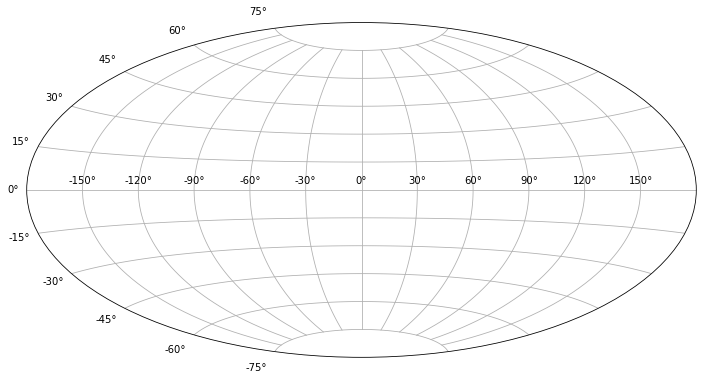

In [97]:
# Create a matplotlib canvas
fig = plt.figure(figsize=(12,12))

# We will be using the `aitoff` projection for a globe canvas
ax = plt.subplot(111, projection='aitoff')

plt.plot(30*u.radian, 30*u.radian)
plt.grid()

In [57]:
tables = []

for row in filtered_observations:
    ra, dec, t_min = row["ra"], row["dec"], row["t_min"]
    coords = f'{ra} {dec}'
    observations = Observations.query_criteria(coordinates=coords,
                                               radius=0.1*u.deg,
                                               instrument_name="ACS/WFC",
                                               t_min=[t_min-10, t_min+10])

    tables.append(observations)

In [66]:
ephemeris_observations = unique(vstack(tables), keys="s_ra")
ephemeris_observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str3,str6,str7,str3,str12,str7,str30,str89,str36,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str93,float64,str5,str3,int64,str982,str86,str35,str6,bool,float64,str8,str9,str9,float64
science,HST,CALACS,ACS/WFC,HST,F775W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis06010,290.9112348543,-27.90621726673,image,"Hines, Dean C.",3,56979.505933368055,56979.51200949074,300.0,690.0,860.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57344.94012718,13863,GO,--,POLYGON -69.07205442999998 -27.91834206 -69.072058317717648 -27.918294549551291 -69.070418239999981 -27.91807766 -69.072739870000021 -27.88970302 -69.103821919999973 -27.89381052 -69.103818044368452 -27.893858065783444 -69.105458039999974 -27.89407459 -69.103144859999986 -27.92244975 -69.07205442999998 -27.91834206 -69.07205442999998 -27.91834206,mast:HST/product/jcis06010_drz.jpg,mast:HST/product/jcis06010_drz.fits,PUBLIC,True,nan,24839235,220744505,220744505,0.0
science,HLA,HLA,ACS/WFC,HLA,F775W,OPTICAL,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f775w_02,290.9112370596945,-27.906209096905478,image,Hines,2,56979.50594,56979.50769,150.0,690000000000.0,860000000000.0,--,57344.94012718,13863,HLA,--,POLYGON J2000 290.89684960 -27.92245030 290.92793670 -27.91833760 290.92562020 -27.88996640 290.89454110 -27.89407850 290.89684960 -27.92245030,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_06_acs_wfc_f775w_02,--,PUBLIC,--,nan,25981137,67948404,67948404,0.0
science,HLA,HLA,ACS/WFC,HLA,F775W,OPTICAL,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f775w_01,290.9128770096229,-27.905945046863923,image,Hines,2,56979.51028,56979.51203,150.0,690000000000.0,860000000000.0,--,57344.94012718,13863,HLA,--,POLYGON J2000 290.89618110 -27.89381480 290.89848990 -27.92218630 290.92957680 -27.91807330 290.92725980 -27.88970230 290.89618110 -27.89381480,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_06_acs_wfc_f775w_01,--,PUBLIC,--,nan,25981136,67948403,67948403,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
science,HLA,HLA,ACS/WFC,HLA,F606WPOL120V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f606wpol120v_02,290.9515617429132,-27.8989740579249,image,Hines,2,56979.63531,56979.64441,785.0,nan,nan,--,57344.94447902,13863,HLA,--,POLYGON J2000 290.96840030 -27.91120560 290.96605180 -27.88259820 290.93472710 -27.88674040 290.93706730 -27.91534840 290.96840030 -27.91120560,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_06_acs_wfc_f606wpol120v_02,--,PUBLIC,--,nan,25981129,67948396,67948396,79.59876034915891
science,HLA,HLA,ACS/WFC,HLA,F606WPOL120V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f606wpol120v_07,290.95544179257433,-27.897420057724133,image,Hines,2,56979.647,56979.6561,785.0,nan,nan,--,57344.94447902,13863,HLA,--,POLYGON J2000 290.93860690 -27.88518760 290.94094900 -27.91379480 290.97228050 -27.90965040 290.96993020 -27.88104380 290.93860690 -27.88518760,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_06_acs_wfc_f606wpol120v_07,--,PUBLIC,--,nan,25981134,67948401,67948401,92.31719114373594
science,HLA,HLA,ACS/WFC,HLA,F606WPOL120V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_06_acs_wfc_f606wpol120v_04,290.958971742416,-27.896776007673772,image,Hines,2,56979.65826,56979.66736,785.0,nan,nan,--,57344.94447902,13863,HLA,--,POLYGON J2000 290.97581000 -27.90900620 290.97345980 -27.88040010 290.

In [58]:
set(ephemeris_observations["target_name"])

{'COMET-67P-CHURYUMOV-GERASIMENK'}

In [74]:
ephemeris_observations.sort("t_min")
ephemeris_observations["dataURL"] == filtered_observations["dataURL"]

masked_array(data=[True, --, --, True, --, --, --, --, --, --, --, --],
             mask=[False,  True,  True, False,  True,  True,  True,  True,
                    True,  True,  True,  True],
       fill_value=True)

## Resources

The following is a list of resources that were referenced throughout the tutorial, as well as some additional references that you may find useful:

* https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries

## Citations

If you use any of astroquery's tools for published research, please cite the authors. Follow this link for more information about citing astroquery:

* [Citing astroquery](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)

## About This Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu. <br>
<br>
Author(s): Jenny V. Medina <br>
Keyword(s): Tutorial, astroquery, wildcards, moving, target <br>
Last Updated: Jun 2023